## Modelo predictivo Prophet de Meta

In [1]:
# Importamos las librerías y cargamos el fichero de la serie temporal
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

c:\Users\UX530\Desktop\TFM-GIT\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
path_file_train='C:/Users/UX530/Desktop/TFM-GIT/Datasets_Files/ts_train.csv'
path_file_test='C:/Users/UX530/Desktop/TFM-GIT/Datasets_Files/ts_test.csv'

df_train = pd.read_csv(path_file_train, sep=',')
df_test = pd.read_csv(path_file_test, sep=',')
print(f"Filas y columnas de la serie temporal: \n {df_train.shape}\nCabecera del dataframe:\n {df_train.head(5)}")
print(f"Los tipos de las variables:\n {df_train.dtypes}")


print(f"Filas y columnas de la serie temporal: \n {df_test.shape}\nCabecera del dataframe:\n {df_test.head(5)}")
print(f"Los tipos de las variables:\n {df_test.dtypes}")

Filas y columnas de la serie temporal: 
 (285, 2)
Cabecera del dataframe:
   Fecha de solicitud  Número de ampliaciones
0         2019-01-20                   104.0
1         2019-01-27                     3.0
2         2019-02-03                    63.0
3         2019-02-10                    23.0
4         2019-02-17                    44.5
Los tipos de las variables:
 Fecha de solicitud         object
Número de ampliaciones    float64
dtype: object
Filas y columnas de la serie temporal: 
 (47, 2)
Cabecera del dataframe:
   Fecha de solicitud  Número de ampliaciones
0         2024-07-07                    13.0
1         2024-07-14                    14.0
2         2024-07-21                    11.0
3         2024-07-28                    13.0
4         2024-08-04                    13.0
Los tipos de las variables:
 Fecha de solicitud         object
Número de ampliaciones    float64
dtype: object


In [3]:
# Renombrar las columnas al formato que Prophet necesita
df = df_train.rename(columns={
    "Fecha de solicitud": "ds",
    "Número de ampliaciones": "y"
})

# Convertir la columna de fecha a datetime
df['ds'] = pd.to_datetime(df['ds'], errors="coerce")

# Quitar filas sin fecha válida 
df = df.dropna(subset=["ds"])

# Ordenar por fecha
df = df.sort_values("ds")

print(df.head())
print(df.tail())

          ds      y
0 2019-01-20  104.0
1 2019-01-27    3.0
2 2019-02-03   63.0
3 2019-02-10   23.0
4 2019-02-17   44.5
            ds     y
280 2024-06-02  16.0
281 2024-06-09  16.0
282 2024-06-16   9.0
283 2024-06-23  13.0
284 2024-06-30  10.0


In [4]:
# Creamos y entrenamos el modelo
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive'
)

m.fit(df)

23:40:26 - cmdstanpy - INFO - Chain [1] start processing
23:40:26 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
# Renombrar las columnas al formato que Prophet necesita
df_test = df_test.rename(columns={
    "Fecha de solicitud": "ds",
    "Número de ampliaciones": "y"
})

# Convertir la columna de fecha a datetime
df_test['ds'] = pd.to_datetime(df_test['ds'], errors="coerce")
df_test['y'] = df_test['y'].round().astype(int)

# Creamos el horizonte de predicción (manual si no hay test)

if df_test.empty:
    # Creamos fechas futuras manualmente (desde 07/07/2025 hasta 31/12/2025)
    future = pd.date_range(start="2024-07-07", end="2025-25-05", freq="W-SUN")
    future = pd.DataFrame({"ds": future})
else:
    # Usar las fechas del test
    future = df_test[["ds"]].copy()

In [6]:
# Realizamos la predicción
forecast = m.predict(future)

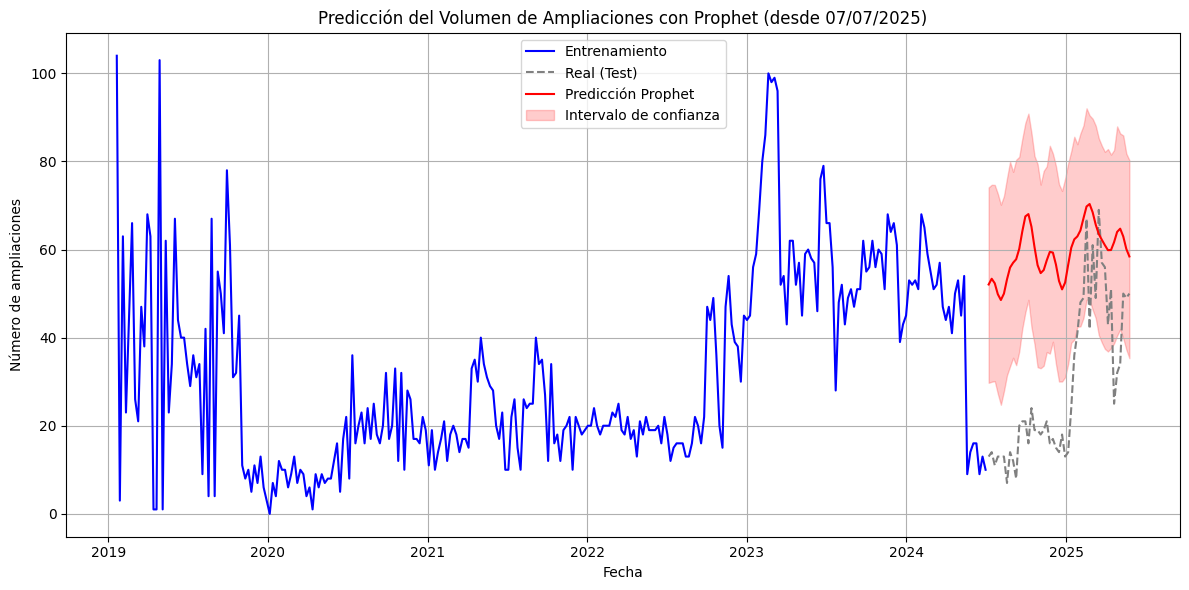

In [7]:
# Visualizamos los resultados:
plt.figure(figsize=(12,6))
plt.plot(df["ds"], df["y"], label="Entrenamiento", color="blue")

if not df_test.empty:
    plt.plot(df_test["ds"], df_test["y"], label="Real (Test)", color="gray", linestyle="--")

plt.plot(forecast["ds"], forecast["yhat"], label="Predicción Prophet", color="red")
plt.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"],
                color="red", alpha=0.2, label="Intervalo de confianza")

plt.title("Predicción del Volumen de Ampliaciones con Prophet (desde 07/07/2025)")
plt.xlabel("Fecha")
plt.ylabel("Número de ampliaciones")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
#Guardamos los resultados.
forecast_out = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]
forecast_out.to_csv("C:/Users/UX530/Desktop/TFM-GIT/Datasets_Files/prophet_forecast_2.csv", index=False)

In [9]:
# =======================================================
# 6. Cálculo de Métricas de Evaluación (RMSE y MAE)
# =======================================================
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 1. Asegurarse de que tenemos datos de prueba
if not df_test.empty:
    # 2. Alinear las predicciones del 'forecast' con los valores reales del 'df_test'
    # La columna 'ds' ya asegura que ambas están ordenadas correctamente.
    
    # Fusionar (Merge) las predicciones con los valores reales usando la columna 'ds'
    # Esto asegura que comparamos la predicción con el valor real de la misma fecha.
    evaluation_df = pd.merge(
        df_test[['ds', 'y']], 
        forecast[['ds', 'yhat']], 
        on='ds', 
        how='inner'
    )
    
    # 3. Extraer valores
    y_true = evaluation_df['y'].values
    y_pred = evaluation_df['yhat'].values
    
    # 4. Calcular Métricas
    
    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)
    
    # Root Mean Squared Error (RMSE)
    # El RMSE es la raíz cuadrada del MSE, lo que lo pone en las mismas unidades que 'y'.
    rmse = np.sqrt(mse)
    
    # Mean Absolute Error (MAE)
    # El MAE es otra métrica robusta que mide la media de las diferencias absolutas.
    mae = mean_absolute_error(y_true, y_pred)
    
    # 5. Imprimir Resultados
    print("="*50)
    print(f"Evaluación del Modelo Prophet en {len(y_true)} períodos (Test):")
    print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
    print(f"MAE (Mean Absolute Error): {mae:.2f}")
    print(f"MSE (Mean Squared Error): {mse:.2f}")
    print("="*50)

    # 6. Opcional: Mostrar la diferencia (error) por fecha
    evaluation_df['error'] = evaluation_df['y'] - evaluation_df['yhat']
    print("\nDesglose de errores (diferencia Real - Predicción):")
    print(evaluation_df.head())
    
else:
    print("No hay datos en el conjunto de prueba (df_test) para realizar la evaluación numérica.")

Evaluación del Modelo Prophet en 47 períodos (Test):
RMSE (Root Mean Squared Error): 33.92
MAE (Mean Absolute Error): 30.91
MSE (Mean Squared Error): 1150.61

Desglose de errores (diferencia Real - Predicción):
          ds   y       yhat      error
0 2024-07-07  13  52.066489 -39.066489
1 2024-07-14  14  53.367592 -39.367592
2 2024-07-21  11  52.332571 -41.332571
3 2024-07-28  13  49.858220 -36.858220
4 2024-08-04  13  48.538683 -35.538683
